<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#paths in git

#root git folder 
#path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from conso.load_shape_data import *

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error


In [4]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload

Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [6]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [7]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [8]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year


In [9]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [10]:
meteo_records.describe()

,snow,floods,storm,hurricane,heavy_rains,cold,hot
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,0.092350,0.077049,0.087432,0.068852,0.087432,0.074863,0.157377
std,0.289598,0.266742,0.282544,0.253272,0.282544,0.263243,0.364255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [12]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [13]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean,variationMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor',
    'load_delta_mean' : 'regressor'
}

# Tools to evaluate the representations

In [14]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

In [15]:
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [16]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [17]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

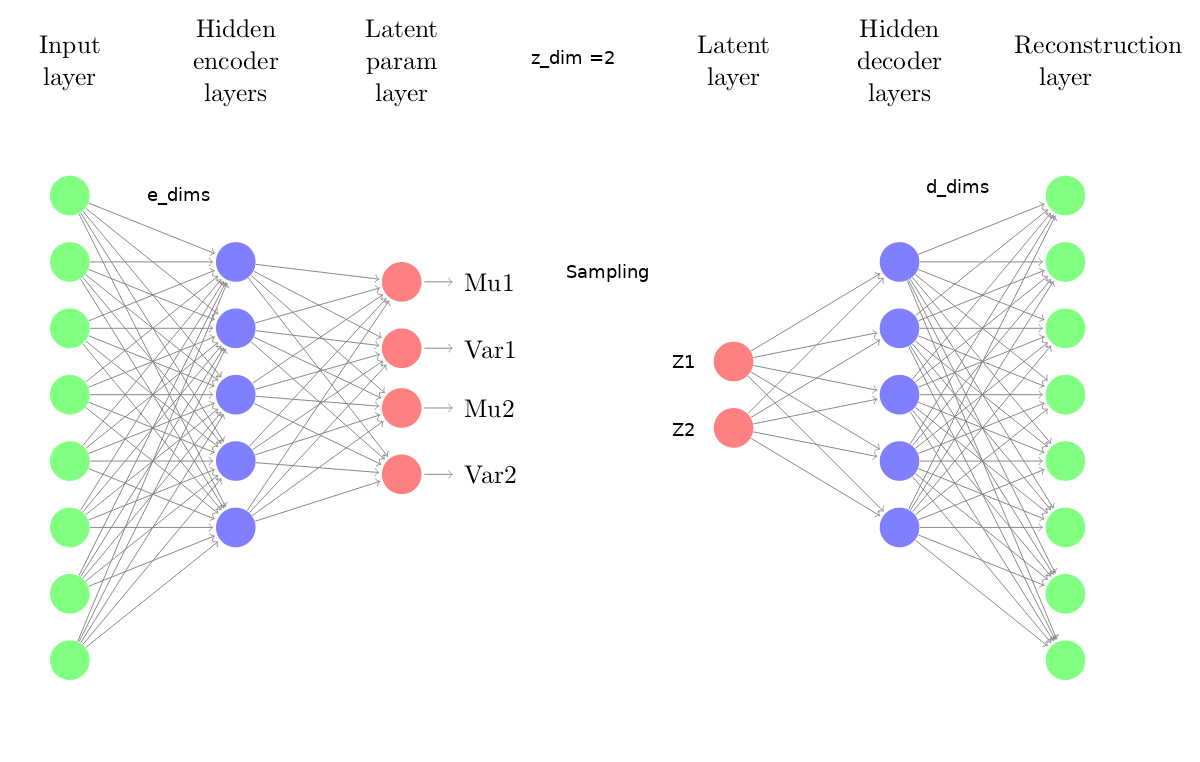

In [18]:
Image(path_main_folder+'/images/VAE.png', width=1000, height=150)

In [19]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,35,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 

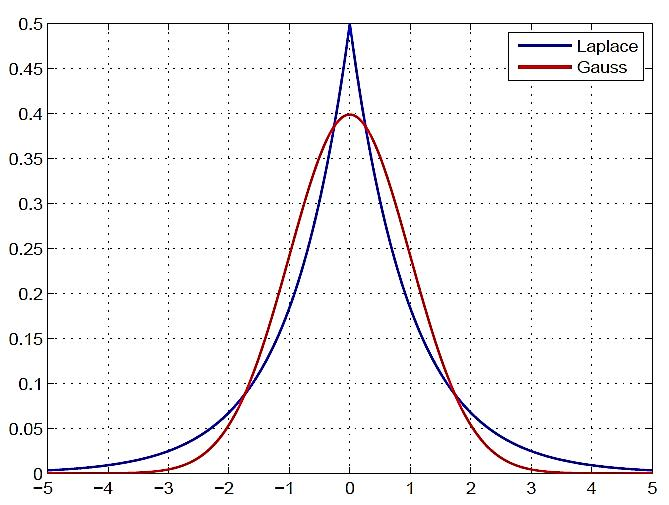

In [20]:
Image(path_main_folder+'/images/lois_laplace_normale.jpg', width=500)


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [21]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du prior univarié exponentiel entre 'Gaussian' et 'Laplace':
prior = 'Laplace'

## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.5, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(8., dtype='float32')

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

In [23]:
# création du modèle
name_model = 'vae'
log_dir_projector=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_vae = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [24]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [25]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    model_vae.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

## Evaluer le modèle

In [26]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    model_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [27]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset['train']['x']
x_encoded, variance = model_vae.encoder.predict(input_encoder)
variance= np.exp(variance)

### Rappels sur les métriques

- Le score d'informativité mesure à quel point des informations préalablements identifiées se retrouvent effectivement dans la représentation latente (erreur de prediction des facteurs K avec l'espace latent);


- Le score de démélement quantifie à quel point les axes latents sont partagés par un ou plusieur facteurs d'importance;

    ==> Calcul : Par dimension i de l'espace latent, $D_i = 1 - H_K(P_i)$ qui représente l'entropie du fait que l'axe soit important pour prédire les facteurs K


- Le score de compacité qui quantifie si un facteur d'importance arrive à aligner les points selon un axe;

    ==> Calcul : Par facteur k de l'espace latent, $D_k = 1 - H_i(P_k)$ qui représente l'entropie de la distribution de $P_k$ le long des axes.


- Le score de Mutual Information Gap, qui quantifie à la fois la reprise d'information dans les axes latents et l'indépendance mutuelle entre ces derniers.

    ==> Calcul : $\frac{1}{k} \sum_k \max_{i,j\in\text{z_dim}} (I(i,k) - I(j,k))$ où I est l'information mutuelle.


Sources :

1) A Framework for the Quantitative Evaluation of Disentangled Representations (C. Eastwood and C. K. I. Williams, ICLR 2018)

2) Isolating Sources of Disentanglement in VAEs (Chen et al., 2018)

Mutual Information Gap : 0.14


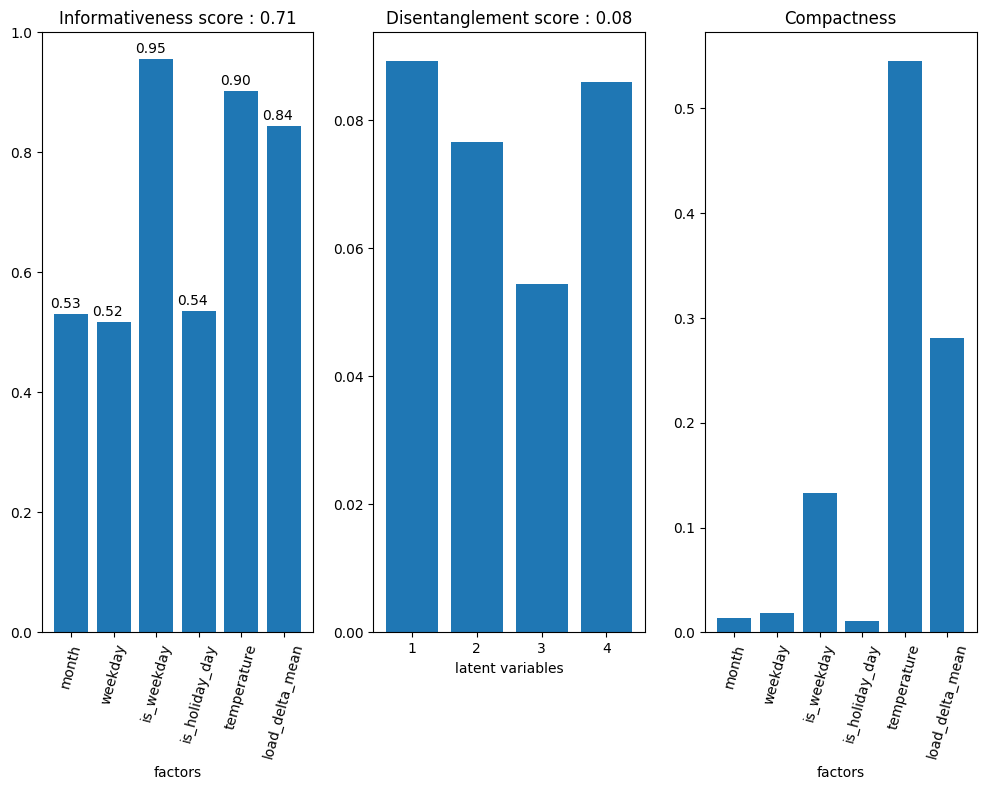

In [28]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

On remarque ici que la température et le booléen "weekend" conditionnent fortement la distribution latente. Visuellement, on peut s'attendre à ce que les moyennes de nos profils journaliers se distribuent selon la température pour un axe, "oui ou non un jour de weekend" pour un autre axe, et un troisième axe informatif qui semble scotcher la pente de charge dans la journée. 

In [29]:
#calculer l'erreur de reconstruction
x = dataset['train']['x'][0]
x_hat = model_vae.cvae.predict(input_encoder)[0]
mae_error = np.mean(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) / 48

## Construction de la représentation explorable avec Tensorboard

In [30]:
all_info = calendar_info.join(meteo_records)
tensorProj = False
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

## Premières interprétations

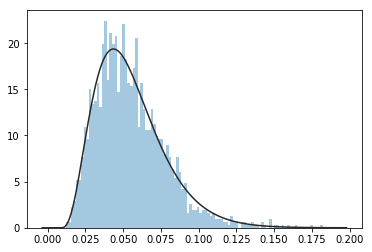

In [31]:
#faire un histogramme des écarts
import seaborn as sn
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100)

In [32]:
#vérification des dates avec la plus grande erreur de reconstruction
nDays=10

decreasingOrderIdx=np.argsort(-mae_error)
calendar_error=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_error['error']=mae_error[decreasingOrderIdx[0:nDays]]
calendar_error

,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday,error
325,2013-11-18,11,0,1,0.0,2013,0.107408,0.0,0.182468
1635,2017-06-20,6,1,1,0.0,2017,0.081715,0.0,0.174049
93,2013-03-31,3,6,0,0.0,2013,0.140812,0.0,0.164348
369,2014-01-01,1,2,1,1.0,2014,0.078078,0.0,0.160032
1403,2016-10-31,10,0,1,0.0,2016,0.090549,1.0,0.156650
821,2015-03-29,3,6,0,0.0,2015,0.102002,0.0,0.152260
1491,2017-01-27,1,4,1,0.0,2017,0.099658,0.0,0.150975
1827,2017-12-29,12,4,1,0.0,2017,0.091277,0.0,0.147803
1465,2017-01-01,1,6,0,1.0,2017,0.081218,0.0,0.147271
1485,2017-01-21,1,5,0,0.0,2017,0.102437,0.0,0.147166


On retrouve ici en premier lieu le 31 mars 2013, qui présente le réajustement du changement d'heure.

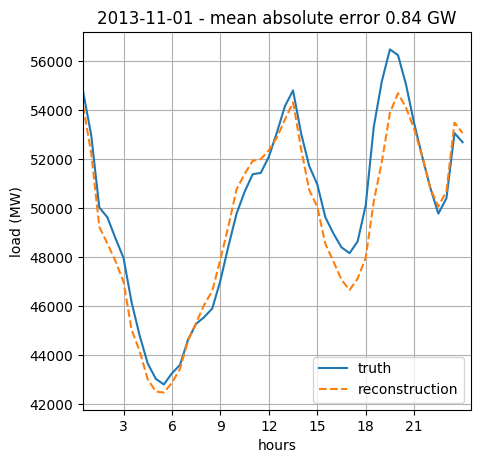

In [33]:
#visualisation des courbes d'un jour donné par son indice
indice=308
display_loads(x[indice,:], x_hat[indice,:], str(dataset['train']['ds'].iloc[indice].date()), mae_error[indice])

### Schéma de recherche des plus proches voisins

- Si pas de date en entrée, prediction des coordonnées latentes (moyenne, variance) avec modèle de regression

$$\mathcal{N}(z|\mu, \Sigma) = regressor(facteurs : température, mois, ...)$$

- Recherche des K plus proches voisins avec une métrique comme la divergence de Kullbach-Leibler (les points sont des distributions à posteriori)

In [34]:
date = '2013-11-01'
KL_div = KL_distance(prior=prior)
search={'date':date}
search_idx = nearest_profiles(search,factorDesc, factorMatrix, calendar_info.ds, x_encoded, variance,metric=KL_div.pairwise, n_neighbors=10, radius=5)
calendar_info.iloc[search_idx]

10 out of 10 neighbors whithin the radius limitation


,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday
308,2013-11-01,11,4,1,1.0,2013,0.087433,0.0
1772,2017-11-04,11,5,0,0.0,2017,0.083579,0.0
1024,2015-10-18,10,6,0,0.0,2015,0.092590,0.0
317,2013-11-10,11,6,0,0.0,2013,0.088232,0.0
1535,2017-03-12,3,6,0,0.0,2017,0.088975,0.0
1348,2016-09-06,9,1,1,0.0,2016,0.077064,0.0
251,2013-09-05,9,3,1,0.0,2013,0.079036,0.0
1395,2016-10-23,10,6,0,0.0,2016,0.087449,0.0
1720,2017-09-13,9,2,1,0.0,2017,0.078899,0.0
654,2014-10-13,10,0,1,0.0,2014,0.097004,0.0


In [48]:
alt_search={'month':11,'is_weekday':calendar_info['is_weekday'].iloc[search_idx[0]], 'temperature':temperatureMean[search_idx[0]]}
alt_search

{'month': 11, 'is_weekday': 1, 'temperature': 10.7468078125}

10 out of 10 neighbors whithin the radius limitation


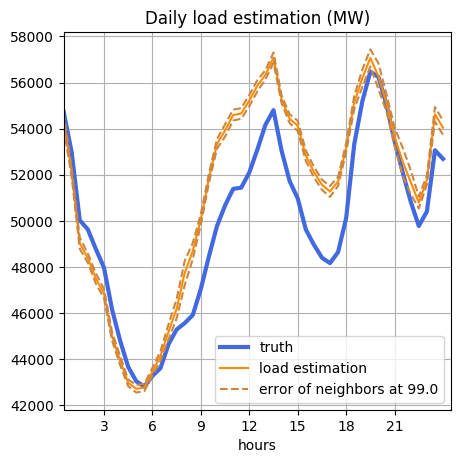

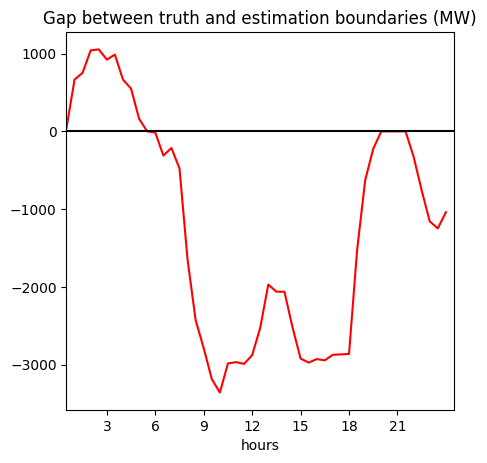

In [49]:
pred_search = generative_estimation(alt_search, model_vae, factorDesc, factorMatrix, dataset, x_encoded, variance, prior, metric=KL_div.pairwise, n_neighbors=10, trust=0.01, x_truth= dataset['train']['x'][0][indice,:], mean_sc=mean_sc, std_sc=std_sc, radius=3)

In [50]:
#analysis of clusters

from sklearn.cluster import AgglomerativeClustering

clt = AgglomerativeClustering(n_clusters=13)
clt.fit(x_encoded)
spec_clt = clt.labels_
dash = '-' * 100
print(dash)
print('{:<6s}{:>10s}{:>20s}{:>20s}{:>40s}'.format('Group', 'Number', 'Is_holiday (%)', 'Is_weekend (%)', 'Month presence order'))
print(dash)

for i in np.unique(spec_clt):
    indix = np.where(spec_clt==i)
    n_i = calendar_info.iloc[indix].shape[0]
    hol_perc = np.sum(calendar_info.iloc[indix]['is_holiday_day'])/n_i
    decomposition, counts = np.unique(calendar_info['month'].loc[indix], return_counts=True)
    month_imp = str(decomposition[np.argsort(counts)[::-1]])
    wkd_perc = 1 - np.sum(calendar_info.iloc[indix]['is_weekday'])/n_i
    print('{:<6.0f}{:>10.0f}{:>20.1f}{:>20.1f}{:>40s}'.format(i, n_i, hol_perc*100, wkd_perc*100, month_imp))
    

----------------------------------------------------------------------------------------------------
Group     Number      Is_holiday (%)      Is_weekend (%)                    Month presence order
----------------------------------------------------------------------------------------------------
0            159                 0.0                 0.0               [ 2  3  4  1 12 11 10  5]
1            174                 3.4                68.4                  [ 8  7  9  6  5 10  4]
2            113                13.3                87.6                  [ 4  5  3 10 12  6  2]
3            159                 0.0                 0.0               [10  9  8  6  7  5  4  3]
4            237                 0.0                 0.0                     [ 1 12  2 11  3 10]
5            159                 0.0                 0.0                         [4 3 5 6 2 9 7]
6            252                 0.0                 0.0         [ 6  7  5  8  4 10  9 11  3 12]
7             88      

On remarque que l'on facilement regrouper les jours de weekend en hiver, voire même différencier le début de semaine du reste. L'été semble plus difficile à différencier.

In [52]:
calendar_info.iloc[np.where(spec_clt==9)].head(10)

,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday
0,2012-12-28,12,4,1,0.0,2012,0.093424,0.0
1,2012-12-29,12,5,0,0.0,2012,0.085615,0.0
2,2012-12-30,12,6,0,0.0,2012,0.084640,0.0
3,2012-12-31,12,0,1,0.0,2012,0.087665,1.0
4,2013-01-01,1,1,1,1.0,2013,0.083204,0.0
6,2013-01-03,1,3,1,0.0,2013,0.099384,0.0
7,2013-01-04,1,4,1,0.0,2013,0.098377,0.0
8,2013-01-05,1,5,0,0.0,2013,0.095950,0.0
9,2013-01-06,1,6,0,0.0,2013,0.095577,0.0
16,2013-01-13,1,6,0,0.0,2013,0.096602,0.0


<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 2. Modèle avec conditions </b> </font> <hr>
</div>

## Construire et entraîner un modèle CVAE

Il s'agit ici de passer en entrée de l'encodeur et du décodeur des informations appelées "conditions" telles que la température ou le mois pour forcer l'encodage à ignorer ces informations et donc rendre la représentation latente indépendante de celles-ci.

Par exemple, essayons avec l'information sur les jours de la semaine.

In [306]:
list_cond = ['day', 'weekday']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond)

day (1830, 7)
weekday (1830, 1)


In [307]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,35,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

In [322]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du prior univarié exponentiel entre 'Gaussian' et 'Laplace':
prior = 'Laplace'

## pour la régularisation de la fonction objectif 
Beta = K.variable(0.4, dtype='float32') # VAE classique --> beta = 1

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(8, dtype='float32')

In [323]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

In [324]:
# création du modèle
name_model = 'cvae'
log_dir_projector=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Usecase/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_cvae = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=dataset_cond['train']['x'][1].shape[1], InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 6287        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [325]:
embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



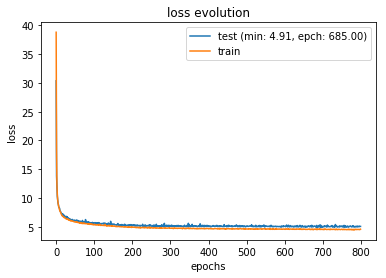

In [326]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    model_cvae.main_train(dataset_cond, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.25)

## Evaluation du modèle

In [327]:
#charger le modèle entrainé si besoin
load_model=1-runTraining
if load_model:
    model_cvae.load_model(os.path.join(path_out, name_model, 'models'))

In [328]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset_cond['train']['x']
x_encoded, variance = model_cvae.encoder.predict(input_encoder)
variance= np.exp(variance)

Mutual Information Gap : 0.12


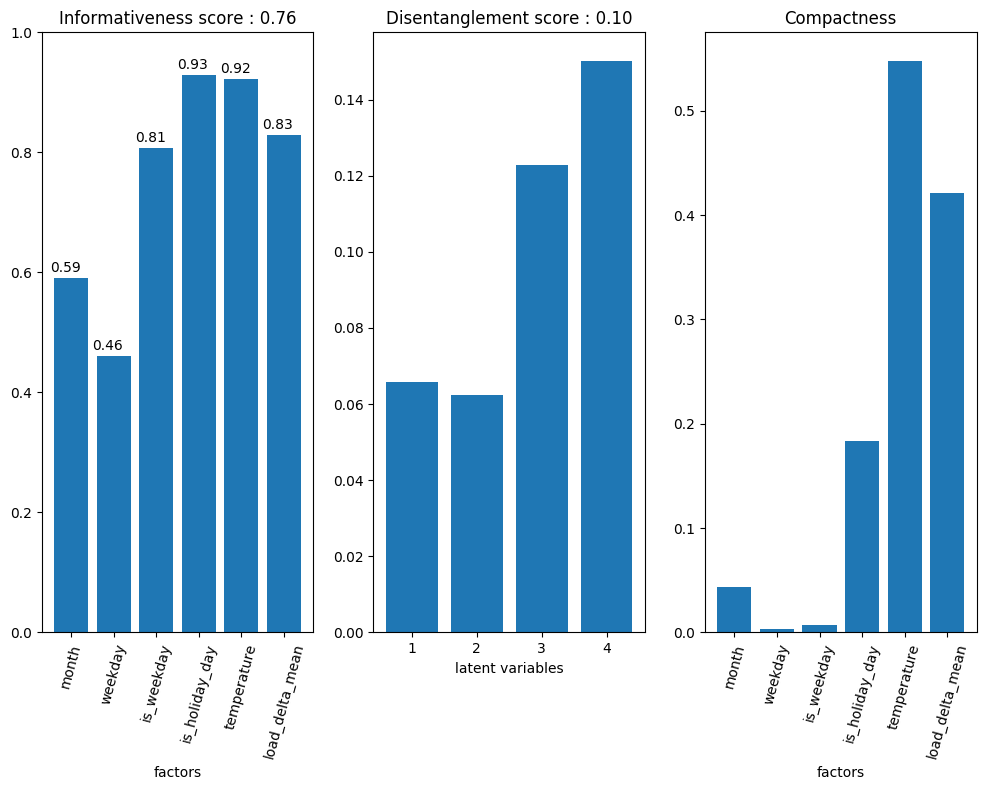

In [329]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

On remarque ici que l'information sur les jours de la semaine, et donc les weekends également, a bien été réduite dans l'espace latent. Les profils se sont donc distribués ici selon un autre facteur, ici selon que l'on soit un jour férié ou non.

In [330]:
#calculer l'erreur de reconstruction
x = dataset_cond['train']['x'][0]
x_hat = model_cvae.cvae.predict(input_encoder)[0]
mae_error = np.mean(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) / 48

### Construction de la représentation explorable avec Tensorboard

In [354]:
tensorProj = False
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/Usecase/cvae/projector


<Figure size 432x288 with 0 Axes>

### Analyses de la distribution latente

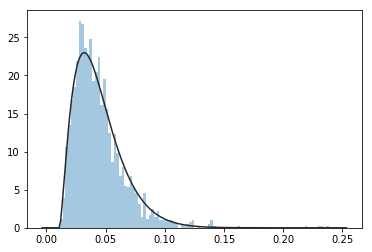

In [332]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100);

In [333]:
#vérification des dates avec la plus grande erreur de reconstruction
nDays=10

decreasingOrderIdx=np.argsort(-mae_error)
calendar_error=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_error['error']=mae_error[decreasingOrderIdx[0:nDays]]
calendar_error

,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday,error
1483,2017-01-19,1,3,1,0.0,2017,0.108659,0.0,0.238520
1484,2017-01-20,1,4,1,0.0,2017,0.110567,0.0,0.231784
1404,2016-11-01,11,1,1,1.0,2016,0.085313,0.0,0.231582
1485,2017-01-21,1,5,0,0.0,2017,0.102437,0.0,0.219707
1403,2016-10-31,10,0,1,0.0,2016,0.090549,1.0,0.161878
95,2013-04-02,4,1,1,0.0,2013,0.094639,0.0,0.142811
1465,2017-01-01,1,6,0,1.0,2017,0.081218,0.0,0.140815
1458,2016-12-25,12,6,0,1.0,2016,0.074145,0.0,0.140636
93,2013-03-31,3,6,0,0.0,2013,0.140812,0.0,0.140525
1461,2016-12-28,12,2,1,0.0,2016,0.097650,0.0,0.139783


On remarque ici à nouveau le profil de changement d'heure du 31 mars 2013. 

In [334]:
search={'is_holiday_day':1, 'temperature':0}
search_idx = nearest_profiles(search,factorDesc, factorMatrix, calendar_info.ds, x_encoded, variance,metric=KL_div.pairwise, n_neighbors=10, radius=4)
print(temperatureMean[search_idx])
calendar_info.iloc[search_idx]


10 out of 10 neighbors whithin the radius limitation
[3.67153646 3.45185052 3.84683594 3.86811458 4.06976198 6.07936354
 5.34953854 2.35362917 5.07069167 3.10446406]


,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday
350,2013-12-13,12,4,1,0.0,2013,0.102092,0.0
1817,2017-12-19,12,1,1,0.0,2017,0.103892,0.0
776,2015-02-12,2,3,1,0.0,2015,0.109417,0.0
763,2015-01-30,1,4,1,0.0,2015,0.101220,0.0
1804,2017-12-06,12,2,1,0.0,2017,0.096028,0.0
1808,2017-12-10,12,6,0,0.0,2017,0.086290,0.0
1474,2017-01-10,1,1,1,0.0,2017,0.098995,0.0
1466,2017-01-02,1,0,1,0.0,2017,0.101110,0.0
1818,2017-12-20,12,2,1,0.0,2017,0.094177,0.0
1798,2017-11-30,11,3,1,0.0,2017,0.100522,0.0


10 out of 10 neighbors whithin the radius limitation


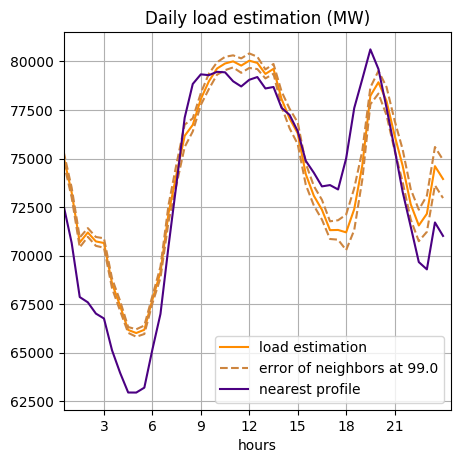

In [335]:
pred_search = generative_estimation(search, model_cvae, factorDesc, factorMatrix, dataset_cond, x_encoded, variance, prior, metric=KL_div.pairwise, n_neighbors=10, trust=0.01, mean_sc=mean_sc, std_sc=std_sc, radius=3)

### Analyse détaillée de la prédiction des jours fériés

In [336]:
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
x_encoded_Hd=x_encoded[indicesHd,]
variance_Hd = variance[indicesHd,]

In [337]:
#Quels sont les jours fériés que l'on prédit mal ?
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)
indices_Hd_not_predicted=[i for i in indicesHd if results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_not_predicted]

,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday
198,2013-07-14,7,6,0,1.0,2013,0.071592,0.0
308,2013-11-01,11,4,1,1.0,2013,0.087433,0.0
673,2014-11-01,11,5,0,1.0,2014,0.088639,0.0
960,2015-08-15,8,5,0,1.0,2015,0.064512,0.0
1038,2015-11-01,11,6,0,1.0,2015,0.085421,0.0
1220,2016-05-01,5,6,0,1.0,2016,0.071816,0.0
1227,2016-05-08,5,6,0,1.0,2016,0.071563,0.0
1458,2016-12-25,12,6,0,1.0,2016,0.074145,0.0
1465,2017-01-01,1,6,0,1.0,2017,0.081218,0.0
1779,2017-11-11,11,5,0,1.0,2017,0.086583,0.0


On remarque que la majorité des jours fériés que l'on prédit mal sont des jours de weekend. Un jour férié arrivant un weekend ne perturbe donc pas le comportement des consommateurs le weekend (ouf !).

### Recherche des points atypiques

DescribeResult(nobs=1830, minmax=(0.07687903672394103, 54.515581252198174), mean=7.903234449951928, variance=56.29764974325095, skewness=1.8411199057920913, kurtosis=4.525731734532808)

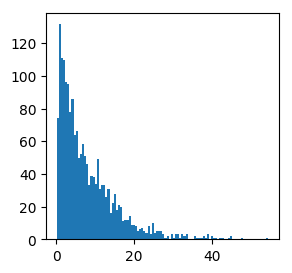

In [338]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10, metric = KL_div.pairwise)
latent = np.concatenate([x_encoded, variance], axis=1)
neigh.fit(latent)

[distance_knn,kneighbors]=neigh.kneighbors(latent, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

stats.describe(nearest)

In [343]:
nearestThreshold=35
calendar_info.join(meteo_records).iloc[np.where(nearest>=nearestThreshold)]

,ds,month,weekday,is_weekday,is_holiday_day,year,load_variation_mean,potential_bridge_holiday,snow,floods,storm,hurricane,heavy_rains,cold,hot
3,2012-12-31,12,0,1,0.0,2012,0.087665,1.0,0,0,0,0,0,0,0
19,2013-01-16,1,2,1,0.0,2013,0.104395,0.0,1,1,0,0,1,1,0
29,2013-01-26,1,5,0,0.0,2013,0.098926,0.0,1,1,0,0,1,1,0
66,2013-03-04,3,0,1,0.0,2013,0.114117,0.0,0,1,0,1,1,0,0
94,2013-04-01,4,0,1,1.0,2013,0.082213,0.0,1,0,0,0,0,1,0
311,2013-11-04,11,0,1,0.0,2013,0.105251,0.0,0,0,0,0,0,0,0
435,2014-03-08,3,5,0,0.0,2014,0.092372,0.0,0,0,0,0,0,0,1
439,2014-03-12,3,2,1,0.0,2014,0.100459,0.0,0,0,0,0,0,0,1
447,2014-03-20,3,3,1,0.0,2014,0.095161,0.0,0,0,0,0,0,0,1
455,2014-03-28,3,4,1,0.0,2014,0.098962,0.0,0,0,0,0,0,0,0


In [353]:
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[np.where(nearest>=nearestThreshold)].describe())

            snow     floods  storm  hurricane  heavy_rains       cold  \
count  22.000000  22.000000   22.0  22.000000    22.000000  22.000000   
mean    0.318182   0.136364    0.0   0.136364     0.136364   0.318182   
std     0.476731   0.351250    0.0   0.351250     0.351250   0.476731   
min     0.000000   0.000000    0.0   0.000000     0.000000   0.000000   
25%     0.000000   0.000000    0.0   0.000000     0.000000   0.000000   
50%     0.000000   0.000000    0.0   0.000000     0.000000   0.000000   
75%     1.000000   0.000000    0.0   0.000000     0.000000   1.000000   
max     1.000000   1.000000    0.0   1.000000     1.000000   1.000000   

             hot  is_holiday_day  potential_bridge_holiday  
count  22.000000       22.000000                 22.000000  
mean    0.227273        0.181818                  0.045455  
std     0.428932        0.394771                  0.213201  
min     0.000000        0.000000                  0.000000  
25%     0.000000        0.000000     

On remarque ici la 2e partie du mois de janvier 2017, qui correspond en fait à un fort épisode neigeux en France. On remarque également quelques jours plus chauds ou plus froids que la normale.  

In [345]:
#essais avec le module PyOD
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.lscp import LSCP
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS

detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [387]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.2
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)
}

#### Angle-based Outlier Detector (local):

It considers the relationship between each point and its neighbor(s). It does not consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score.

In [388]:
i=0
clf_name, clf = list(classifiers.items())[i]
print(i + 1, 'fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

1 fitting Angle-based Outlier Detector (ABOD)
list of 370 most probable outliers for Angle-based Outlier Detector (ABOD)
snow                        0.194595
floods                      0.081081
storm                       0.037838
hurricane                   0.091892
heavy_rains                 0.100000
cold                        0.148649
hot                         0.145946
is_holiday_day              0.113514
potential_bridge_holiday    0.029730
Name: mean, dtype: float64


#### Isolation Forest (global)

In this method, data partitioning is done using a set of trees. Isolation Forest provides an anomaly score looking at how isolated the point is in the structure. The anomaly score is then used to identify outliers from normal observations.

In [389]:
i=1
clf_name, clf = list(classifiers.items())[i]
print(i + 1, 'fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

2 fitting Isolation Forest
list of 366 most probable outliers for Isolation Forest
snow                        0.188525
floods                      0.065574
storm                       0.087432
hurricane                   0.073770
heavy_rains                 0.090164
cold                        0.155738
hot                         0.199454
is_holiday_day              0.128415
potential_bridge_holiday    0.021858
Name: mean, dtype: float64


#### Local Outlier Factor (local)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. 

In [390]:
i=2
clf_name, clf = list(classifiers.items())[i]
print(i + 1, 'fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

3 fitting Local Outlier Factor (LOF)
list of 352 most probable outliers for Local Outlier Factor (LOF)
snow                        0.190341
floods                      0.062500
storm                       0.051136
hurricane                   0.088068
heavy_rains                 0.079545
cold                        0.176136
hot                         0.190341
is_holiday_day              0.142045
potential_bridge_holiday    0.034091
Name: mean, dtype: float64


#### Locally Selective Combination of Parallel Outlier Ensembles (local)

In [391]:
i=3
clf_name, clf = list(classifiers.items())[i]
print(i + 1, 'fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

4 fitting Locally Selective Combination (LSCP)
list of 365 most probable outliers for Locally Selective Combination (LSCP)
snow                        0.183562
floods                      0.068493
storm                       0.060274
hurricane                   0.084932
heavy_rains                 0.082192
cold                        0.169863
hot                         0.200000
is_holiday_day              0.134247
potential_bridge_holiday    0.030137
Name: mean, dtype: float64


#### Histogram-base Outlier Detection (global)

It is an efficient unsupervised method which assumes the feature independence and calculates the outlier score by building histograms.

In [392]:
i=4
clf_name, clf = list(classifiers.items())[i]
print(i + 1, 'fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

5 fitting Histogram-base Outlier Detection (HBOS)
list of 354 most probable outliers for Histogram-base Outlier Detection (HBOS)
snow                        0.124294
floods                      0.059322
storm                       0.132768
hurricane                   0.042373
heavy_rains                 0.079096
cold                        0.107345
hot                         0.220339
is_holiday_day              0.124294
potential_bridge_holiday    0.022599
Name: mean, dtype: float64


#### Cluster-based Local Outlier Factor (local)

It classifies the data into small clusters and large clusters. The anomaly score is then calculated based on the size of the cluster the point belongs to, as well as the distance to the nearest large cluster.

In [393]:
i=5
clf_name, clf = list(classifiers.items())[i]
print(i + 1, 'fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

6 fitting Cluster-based Local Outlier Factor (CBLOF)
list of 366 most probable outliers for Cluster-based Local Outlier Factor (CBLOF)
snow                        0.322404
floods                      0.065574
storm                       0.000000
hurricane                   0.133880
heavy_rains                 0.081967
cold                        0.232240
hot                         0.024590
is_holiday_day              0.046448
potential_bridge_holiday    0.008197
Name: mean, dtype: float64


In [423]:
# pour le meilleur détecteur de jours météo, amélioration ?

clf = CBLOF(n_clusters=10,contamination=0.2,check_estimator=False, random_state=random_state)
clg_name='best_CBLOF'
print('fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_encoded)
outliers = clf.predict(x_encoded)
print('list of {} most probable outliers for '.format(np.sum(outliers))+clf_name)
print(meteo_records.join(calendar_info[['is_holiday_day', 'potential_bridge_holiday']]).iloc[outliers==1].describe().iloc[1])

fitting Cluster-based Local Outlier Factor (CBLOF)
list of 366 most probable outliers for Cluster-based Local Outlier Factor (CBLOF)
snow                        0.336066
floods                      0.079235
storm                       0.008197
hurricane                   0.158470
heavy_rains                 0.103825
cold                        0.245902
hot                         0.035519
is_holiday_day              0.062842
potential_bridge_holiday    0.008197
Name: mean, dtype: float64


In [399]:
np.sum(meteo_records['snow'])

169